Top frequencies:  [1941.32252633  658.58043894  881.87448272 1718.02848255  658.23796341
 1941.66500186  987.87065841 1612.03230686 1941.15128856  658.7516767 ] Hz


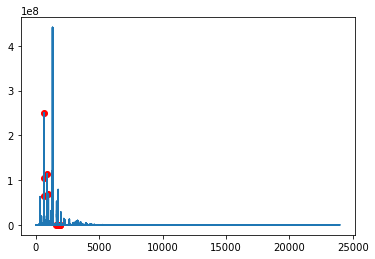

In [89]:
import numpy as np
from scipy.io.wavfile import read
from scipy.fftpack import fft
import matplotlib.pyplot as plt

# Read the file (assumes you have converted mp3 to wav)
sampling_rate, data = read('AFL Siren Sound Effect.wav')

# If the audio file is stereo (two channels), we need to convert it to mono
if len(data.shape) > 1 and data.shape[1] > 1:
    data = np.mean(data, axis=1)

# Take the FFT
fft_out = fft(data)

# Generate the frequencies associated with the FFT output
frequencies = np.abs(np.fft.fftfreq(len(fft_out), 1.0/sampling_rate))


# Only consider frequencies in the "lower" range of human hearing
mask = (frequencies < 1300)

# Find the top N frequencies within this mask
N = 10
indices = (-np.abs(fft_out[mask])).argsort()[:N]
top_frequencies = frequencies[indices]
print('Top frequencies: ', top_frequencies, 'Hz')

# Plot the absolute value of the FFT output versus frequency
plt.plot(frequencies, np.abs(fft_out))
plt.scatter(top_frequencies, np.abs(fft_out)[indices], color='r')  # Mark top frequencies
plt.show()



In [90]:
import numpy as np
from scipy.io.wavfile import write

# Settings
sample_rate = 44100  # Sample rate in Hz
duration = 5.0  # seconds

# Generate the time values for each sample
t = np.arange(int(sample_rate * duration)) / sample_rate

# Generate the audio signal by summing sine waves for each top frequency
signal = np.zeros(len(t))
for frequency in top_frequencies:
    signal += 0.05 * np.sin(2 * np.pi * frequency * t)

# Write to .wav file
write('combined_sine_waves.wav', sample_rate, signal)
